In [1]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

DIM = 3
modello = 'Anderson'


def base_dir(model, d):
    """
    Base directory for input model for d-dimension
    """
    return f"../results/{model}/dim={d}/PBC/"

print(base_dir(modello, DIM))

/Users/rafal.swietek/Projects/QHamSolver/Quadratic/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
../results/Anderson/dim=3/PBC/


In [2]:

def order_of_magnitude2(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def order_of_magnitude(a_value):
    x = a_value - int(a_value)
    x = np.round(x, 8)
    num_str = f"{x}"
    num_str = num_str[2:]
    _size = len(num_str)
    if num_str == "0":
        _size = 0;
    
    return _size
    
def info_raw(L, J, w, g, model = 'Anderson', use_old = False):
    
    names = ['J', 'w', 'g']
    arr = [J]
    if model == 'Anderson' or model == 'AubryAndre': arr.append(w)
    if model == 'AubryAndre': arr.append(g)
    
    info = "_L=%d"%(L)
    for i, var in enumerate(arr):
        n = order_of_magnitude2(var) if use_old else order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info

def info(L, J=1.0, w=0.0, g=0.0, use_old = False, model = 'Anderson', ext = '.dat'):
    return info_raw(L, J, w, g, model, use_old) + ext


def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data


def page(L_a, L_b):
    # return L_a * np.log(2)
    d_a = 2**L_a
    d_b = 2**L_b
    print(d_a, L_a)
    print(d_b, L_b)
    return digamma(d_a * d_b + 1) - digamma(max(d_a, d_b) + 1) - (min(d_a, d_b) - 1) / (2 * max(d_a, d_b))

# ANDERSON

In [3]:
J=1
w = 6
DIM=1

for w in [6.0]:
    # for L in np.arange(4, 18, 2):
    for L in [18, 20, 22]:
        entropy = np.zeros((100))
        single_site_entropy = np.zeros((100))
        counter = 0
        for jobid in np.arange(0, 1, 5):
            name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model = 'Anderson', ext=f'_jobid={jobid}.hdf5')
            if exists(name):
                with h5py.File(name, "r") as file:
                    S = np.array(file.get('entropy')[0])
                    S_site = np.array(file.get('single_site_entropy')[0])

                    entropy += S
                    single_site_entropy += S_site
                    counter += 1
            else:
                print(name)
        if counter > 0:
            name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')

            hf = h5py.File(name, 'w')
            hf.create_dataset('entropy',                entropy.shape,              data = entropy / counter)
            hf.create_dataset('single_site_entropy',    single_site_entropy.shape,  data = single_site_entropy / counter)

            hf.close()


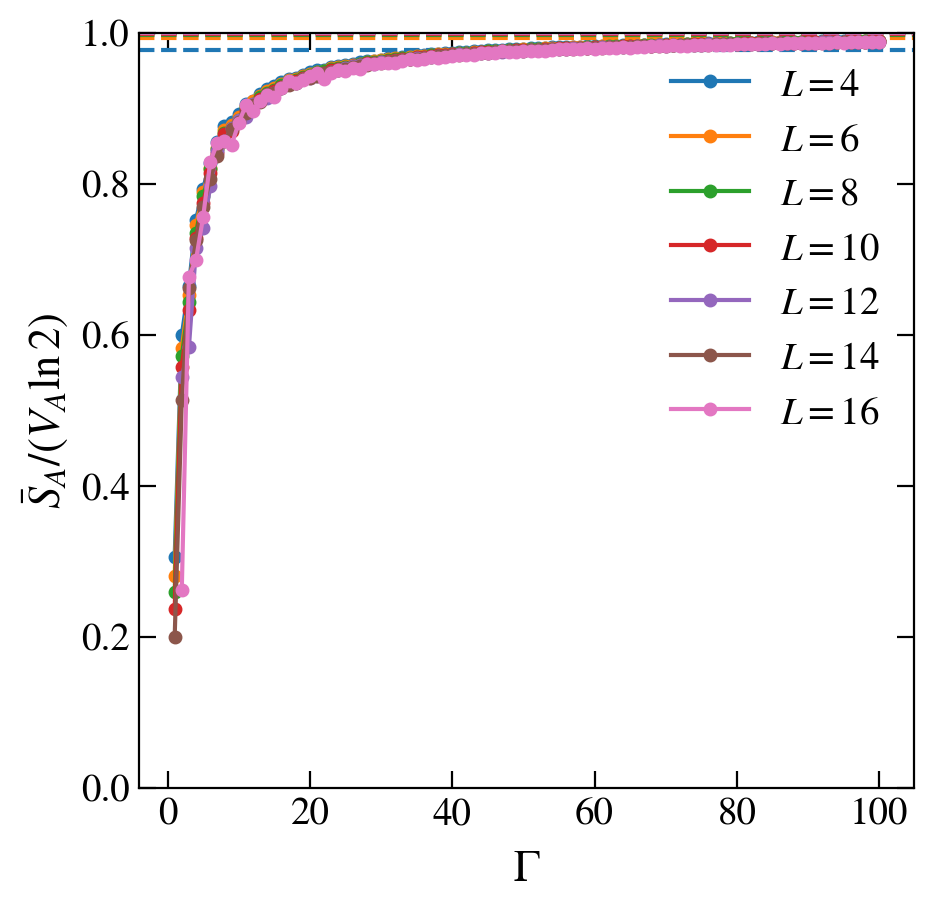

In [28]:
L = 100
w = 27
J = 1
DIM=3


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

for L in np.arange(4, 17, 2):
# for L in [20, 50, 100, 500, 1000, 2000]:
    V = L**DIM
    

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            pl = axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), marker='o', markersize=4, label=r"$L=%d$"%(L))
    else:
        print(name)
    # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
    axis.axhline(y = 1 - 1. / (V*np.log(2)), color=pl[0].get_color(), ls='--')

fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.0, 1.0), xscale='linear')
# axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)

# AUBRY-ANDRE

In [10]:
J=1
w = 2
g = 3

for w in [1.0, 4.0]:
    for g in [0.618, 1.618]:
        for L in [18, 20, 22]:#np.arange(50, 250, 50):
            entropy = np.zeros((200))
            single_site_entropy = np.zeros((200))
            counter = 0
            for jobid in np.arange(0, 1, 5):
                name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model = 'AubryAndre', ext=f'_jobid={jobid}.hdf5')
                if exists(name):
                    with h5py.File(name, "r") as file:
                        S = np.array(file.get('entropy')[0])
                        S_site = np.array(file.get('single_site_entropy')[0])

                        entropy += S
                        single_site_entropy += S_site
                        counter += 1
                else:
                    print(name)
            if counter > 0:
                name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')

                hf = h5py.File(name, 'w')
                hf.create_dataset('entropy',                entropy.shape,              data = entropy / counter)
                hf.create_dataset('single_site_entropy',    single_site_entropy.shape,  data = single_site_entropy / counter)

                hf.close()


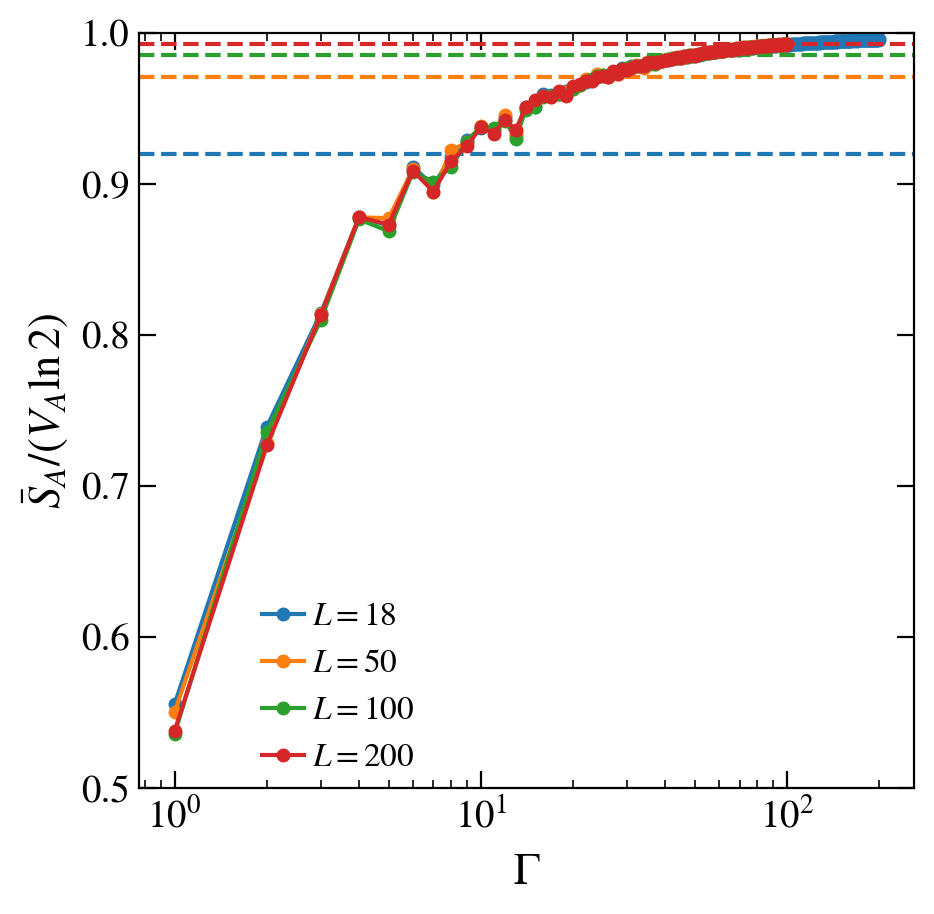

In [13]:
L = 100
w = 1
J = 1
g = 0.618


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

for L in [18, 50, 100, 200]:
    V = L
    

    name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            pl = axis.plot(np.arange(1,S.size+1), S / (V//2*np.log(2)), marker='o', markersize=4, label=r"$L=%d$"%(L))
    else:
        print(name)
    # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
    axis.axhline(y = 1 - 1. / (V*np.log(2)), color=pl[0].get_color(), ls='--')


fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)

# FREE FERMIONS

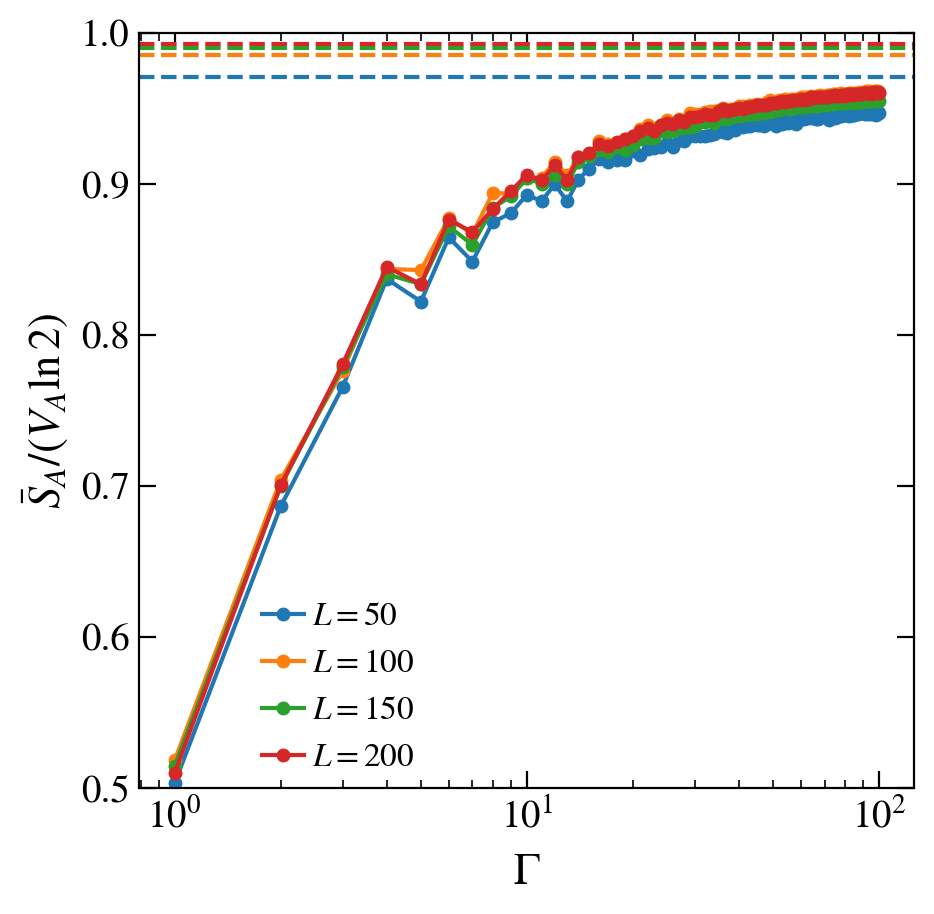

In [26]:
L = 100
w = 1
J = 1
g = 1.618


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

for L in np.arange(50, 250, 50):
    V = L
    

    name = base_dir(model='FreeFermions', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, model='FreeFermions', ext='_jobid=0.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))[0]
            pl = axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), marker='o', markersize=4, label=r"$L=%d$"%(L))
    else:
        print(name)
    # ax_inset.plot(4 * w_vals, ydata, marker='o', markersize=4, label=r"$L=%d$"%(L))
    axis.axhline(y = 1 - 1. / (V*np.log(2)), color=pl[0].get_color(), ls='--')


fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)

# COMPARE MODELS

In [29]:

# XYZ stuff
def info_base(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0):
    arr = [J1, J2, delta1, delta2, eta1, eta2, hx, hz]
    names = ['J1', 'J2','d1', 'd2', 'e1', 'e2', 'hx', 'hz']
    info = "_L=%d"%L
    for i, var in enumerate(arr):
        n = order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    return info

def info_sym(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, k=0, p=1, zx=1, zz=1, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    info += ",k=%d"%k
    if (k==0 or k==L/2):                                info += ",p=%d"%p
    if hz == 0 and not edge and (L % 2 == 0 or hx != 0):info += ",zx=%d"%zx
    if hx == 0:                                         info += ",zz=%d"%zz
    info += ",edge=%d"%edge
    return info

parity_sectors = [-1, 1]
def get_sectors(L, hx, hz):
    translation_real_sectors = [0, L // 2]
    translation_imag_sectors = range(1, L // 2 + L % 2)
    
    spin_flip_Z_sectors = [-1, 1] if hx == 0 else [1]
    spin_flip_X_sectors = [-1, 1] if hz == 0 and (L % 2 == 0 or hx != 0) else [1]

    real_sectors = [[ks, ps, zx, zz] for ks in translation_real_sectors for ps in parity_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]
    imag_sectors = [[kx, 1, zx, zz] for kx in translation_imag_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]

    return real_sectors, imag_sectors


def info_dis(L, J1=0, J2=0, delta1=0, delta2=0, eta1=0, eta2=0, hx=0, hz=0, w=0, pb=0, edge = False):
    info = info_base(L, J1, J2, delta1, delta2, eta1, eta2, hx, hz)
    n = order_of_magnitude(w)
    info +=  str(",w={:.%df}"%n).format(round(w, n))
    info += ",edge=%d"%edge
    info += ",pb=%d"%pb
    return info

waaaaaaa 29144.0 262144
512 9
512 9


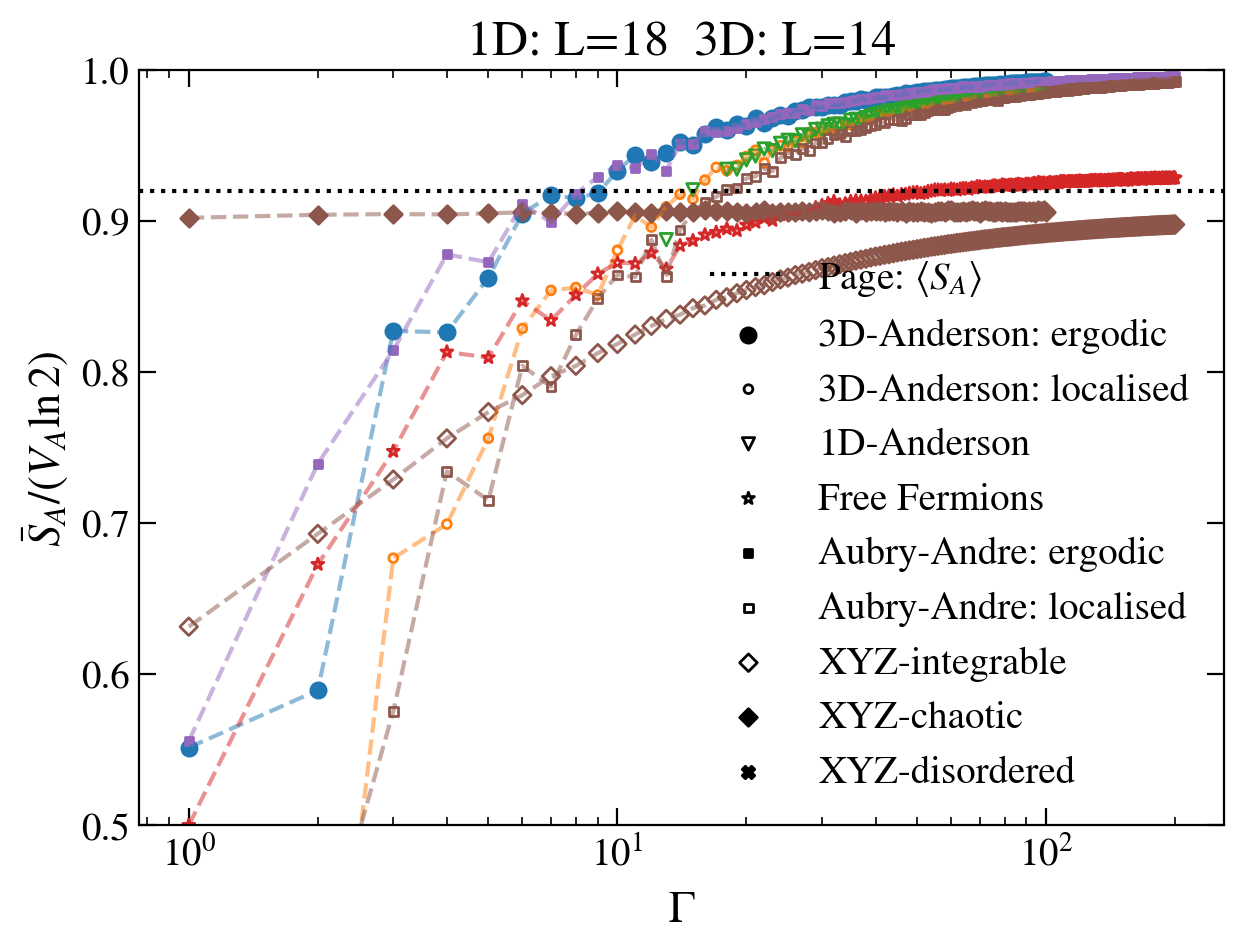

In [35]:
L = 16
w = 6
J = 1
DIM=3


fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(7,5), dpi = 200)

# ax_inset = fig_help.add_subplot_axes(axis, fig, [0.5, 0.5, 0.46, 0.46])

colors_ls_cyc = itertools.cycle(colors_ls)
for L in [L]:
# for L in [20, 50, 100, 500, 1000, 2000]:
    V = L**DIM
    
    col = next(colors_ls_cyc)

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='o', s=30)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='o', s=30, label='3D-Anderson: ergodic')

w=27
for L in [L]:
# for L in [20, 50, 100, 500, 1000, 2000]:
    V = L**DIM
    
    col = next(colors_ls_cyc)

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='o', facecolor='None', s=10)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='o', s=10, facecolor='None', label='3D-Anderson: localised')





L=18
w=6
DIM=1
# for L in np.arange(4, 16, 2):
for L in [L]:
    V = L**DIM
    
    col = next(colors_ls_cyc)

    name = base_dir(model='Anderson', d=DIM) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, model='Anderson', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='v', facecolor='None', s=20)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='v', facecolor='None', s=20, label='1D-Anderson')

for L in [L]:
    V = L
    
    col = next(colors_ls_cyc)

    name = base_dir(model='FreeFermions', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, model='FreeFermions', ext='_jobid=0.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))[0]
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='*', facecolor='None', s=20)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='*', facecolor='None', s=20, label='Free Fermions')

w=1
g=0.618
for L in [L]:
    V = L
    
    col = next(colors_ls_cyc)

    name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='s', s=10)
            axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='s', s=10, label='Aubry-Andre: ergodic')

w=4
g=0.618
for L in [L]:
    V = L
    
    col = next(colors_ls_cyc)

    name = base_dir(model='AubryAndre', d=1) + 'Entropy/Degeneracy/' + info(L=L, J=J, w=w, g=g, model='AubryAndre', ext='.hdf5')
    # print(name)
    if exists(name):
        with h5py.File(name, "r") as file:
            S = np.array(file.get('entropy'))
            axis.scatter(np.arange(1, S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='s', facecolor='None', s=10)
            axis.plot(np.arange(1, S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
    else:
        print(name)
axis.scatter(np.nan, np.nan, color='k', marker='s', facecolor='None', s=10, label='Aubry-Andre: localised')

J1=1.0
d1=0.2
e1=0.2
# for L in [L]:
#     V = L
    
#     col = next(colors_ls_cyc)

#     name = '../../XYZ/results/symmetries/PBC/Entropy/Degeneracy/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=0, p=1, zx=1, zz=1) + ".hdf5"
#     # print(name)
#     if exists(name):
#         with h5py.File(name, "r") as file:
#             S = np.array(file.get('entropy'))[V//2]
#             axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='D', facecolor='None', s=20)
#             axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
#     else:
#         print(name)

V = L
LA = L//2
real_sec, imag_sec = get_sectors(L, 0, 0)
sects = real_sec + imag_sec
dim_tot = 0
S = np.zeros((200))
# sects = [[1, 1, 1, 1]]
for [ks, ps, zxs, zzs] in sects:
    name = '../../XYZ/results/symmetries/PBC/Entropy/Eigenstate/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
    found = True
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('energies')[0])
            dim = energies.size
            dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim
    else:
        found = False

    name = '../../XYZ/results/symmetries/PBC/Entropy/Degeneracy/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
    if found and exists(name):
        with h5py.File(name, "r") as file:
            entropies = np.array(file.get('entropy'))[L//2]
            S += dim * entropies if ks == 0 or ks == L / 2 else 2 * dim * entropies

    else:
        print("Not found:", name)
if dim_tot != 2**L:
    print("waaaaaaa", dim_tot, 2**L)
if dim_tot > 0: S /= dim_tot
axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='D', facecolor='None', s=20)
axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
axis.scatter(np.nan, np.nan, color='k', marker='D', facecolor='None', s=20, label=r'XYZ-integrable')

J2=1.0
d2=0.2
e2=0.2
S = np.zeros((100))
dim_tot=0
for [ks, ps, zxs, zzs] in real_sec:
    name = '../../XYZ/results/symmetries/PBC/Entropy/Degeneracy/' + info_sym(L=L, J1=J1, J2=J2, delta1=d1, delta2=d2, eta1=e1, eta2=e2, k=ks, p=ps, zx=zxs, zz=zzs) + ".hdf5"
    if exists(name):
        with h5py.File(name, "r") as file:
            entropies = np.array(file.get('entropy'))[LA]
            dim = np.array(file.get('dim')[0][0])
            dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim
            S += dim * entropies if ks == 0 or ks == L / 2 else 2 * dim * entropies

    else:
        print("Not found:", name)
if dim_tot != 2**L:
    print("waaaaaaa", dim_tot, 2**L)
if dim_tot > 0: S /= dim_tot
axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='D', s=20)
axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
axis.scatter(np.nan, np.nan, color='k', marker='D', s=20, label=r'XYZ-chaotic')
axis.axhline(y = page(LA, L - LA) / (LA*np.log(2)), color='k', ls=':', label=r'Page: $\langle S_A\rangle$')

# L=12
# V=L
# LA = L//2
# d1=0.55
# e1=0.5
# J2=0.0
# d2=0.2
# e2=0.0
# hx=0.5
# w=0.7
# S = np.zeros((100))
# dim_tot=0
# name = '../../XYZ/results/disorder/PBC/Entropy/Degeneracy/' + info_dis(L=L, J1=J1, J2=J2, delta1=d1, delta2=d2, eta1=e1, eta2=e2,hx=hx,w=w) + "_jobid=0.hdf5"
# if exists(name):
#     with h5py.File(name, "r") as file:
#         S = np.array(file.get('entropy'))[LA]
# else:
#     print("Not found:", name)

# axis.scatter(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, marker='X', s=20)
# axis.plot(np.arange(1,S.size+1, 1), S / (V//2*np.log(2)), color=col, ls='--', alpha=0.5)
# axis.scatter(np.nan, np.nan, color='k', marker='X', s=20, label=r'XYZ-disordered')

axis.set_title(f"1D: L={L}\t 3D: L=14", fontsize=18)
fig_help.set_plot_elements(axis, ylabel=r"${\bar{S}_A} / (V_A\ln2)$", xlabel=r"$\Gamma$", font_size=14, set_legend=True, ylim=(0.5, 1.0), xscale='log')
# axis.legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.12,-0.02))

# fig_help.set_plot_elements(ax_inset, ylabel=r"${\bar{S}_A} / \ln2$", xlabel=r"$W$", font_size=14, set_legend=False, xlim=(8.0, 25.0), ylim=(0.7, 1.0))

fig.subplots_adjust(wspace = 0.2, hspace=0.05)